In [4]:
# Import everything maybe needed somewhere
import matplotlib
from scipy import stats
import numpy as np
import pandas as pd
from scipy.io import loadmat
import scipy
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.interpolate import griddata
import os, glob, csv, shutil, sys
sns.set_style("white")
# %matplotlib inline

sys.path.append('/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Code/Task')
from misc import idcs2state, state2idcs, get_new_state, get_a_opp, policy_choose, policy_choose_moves
from misc_analysis import *

In [57]:
root_folder = '/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/'

In [58]:
# World 1
world1 = np.load(os.path.join(root_folder, 'Data/world1.npy'))
world2 = np.load(os.path.join(root_folder, 'Data/world2.npy'))
idcs1  = np.load(os.path.join(root_folder, 'Data/idcs1.npy'))
idcs2  = np.load(os.path.join(root_folder, 'Data/idcs2.npy'))

## Sequenceness

In [7]:
data_path = os.path.join(root_folder, '/Paper/Figures_data/Figure1', 'Figure3c.mat')
data      = loadmat(data_path)

In [8]:
high_seq = [data['first_of_two_moves_high_seq'], data['second_of_two_moves_high_seq'], data['one_move_high_seq']]
low_seq = [data['first_of_two_moves_low_seq'], data['second_of_two_moves_low_seq'], data['one_move_low_seq']]

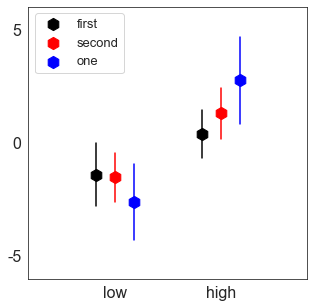

In [9]:
fig = plt.figure(figsize=(5, 5))

c = 0
colours = ['k', 'r', 'b']
labels  = ['first', 'second', 'one']
for i in range(3):
    y = low_seq[i]
    plt.scatter(1+c, np.mean(y), marker='h', c=colours[i], s=150, label=labels[i])
    std = np.std(y, axis=0)
    sem = std/np.sqrt(len(y))
    plt.plot([1+c, 1+c], [np.mean(y)-sem, np.mean(y)+sem], c=colours[i])
    
    y = high_seq[i]
    plt.scatter(2+c, np.mean(y), marker='h', c=colours[i], s=150)
    std = np.std(y, axis=0)
    sem = std/np.sqrt(len(y))
    plt.plot([2+c, 2+c], [np.mean(y)-sem, np.mean(y)+sem], c=colours[i])
    c += 0.18

plt.legend(prop={'size':13})
plt.xlim(0.36, 3)
plt.ylim(-0.06, 0.06)
plt.yticks([-0.05, 0, 0.05], [-5, 0, 5], fontsize=16);
plt.xticks([1.18, 2.18], ['low', 'high'], fontsize=16);

# plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Optimism_And_Pessimism_In_Optimised_Replay/Figures_data/Figure1/panel_3c.svg', format='svg', transparent=True)

### Flexibility

In [10]:
k = np.zeros((40, 4))

for sub in range(40):

    sub_folder = os.path.join(root_folder, 'Data/task/%u'%(sub))
    
    opt_moves11 = 0
    opt_moves12 = 0
    opt_moves21 = 0
    opt_moves22 = 0
    
    # iterate over 5 blocks
    for i in range(5):
        if i == 0:
            this_range = 6
        else:
            this_range = 7
        tmp = []
        
        if i in [0, 1]:
            Q1_true, Q2_true = get_Q_true(world1, idcs1)
        elif i in [2, 3]:
            Q1_true, Q2_true = get_Q_true(world2, idcs1)
        else:
            Q1_true, Q2_true = get_Q_true(world2, idcs2)
        
        for j in range(this_range):
    
            os.chdir(os.path.join(sub_folder, str(i), str(j)))
            all_files = glob.glob('*.npz')

            # Sort files by episode number
            episodes = [int(''.join(c for c in f if c.isdigit())) for f in all_files]
            idcs     = [i[0] for i in sorted(enumerate(episodes), key=lambda x:x[1])]
            all_files_sorted = [all_files[i] for i in idcs] 
            
            for f in range(len(all_files_sorted)):
                this_file = all_files_sorted[f]
                data      = np.load(this_file)
                move      = data['move']
                
                if len(move) != 2:
                    s = move[0]
                    a = move[1]
                    if a in get_optimal_move(s, Q2_true):
                        opt_moves11 += 1
                    elif a in get_optimal_move(s, Q1_true)//4:
                        opt_moves12 += 1

                else:
                    s = move[0][0]
                    a = move[0][1]
                    if a in get_optimal_move(s, Q2_true):
                        opt_moves21 += 1
                    elif a in get_optimal_move(s, Q1_true)//4:
                        opt_moves22 += 1
    
    k[sub, :] = [opt_moves11/(18*5), opt_moves12/(18*5), opt_moves21/(36*5), opt_moves22/(36*5)]

Text(0.5, 1.0, 'Agent')

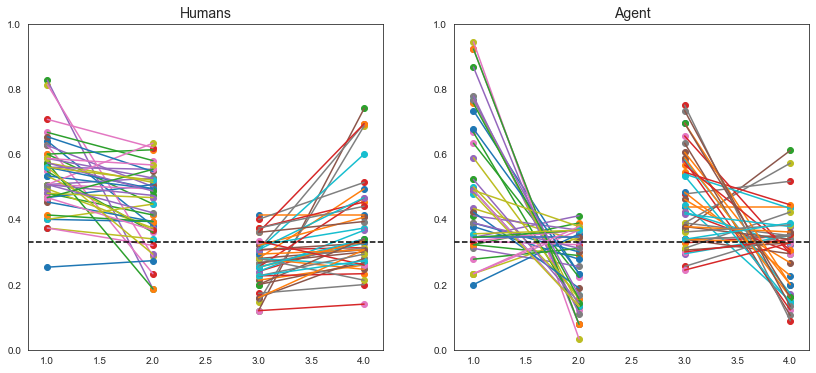

In [11]:
path = os.path.join(root_folder, '/Data/PerformanceSummaries.mat')
data = loadmat(path)

figure = plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)

flex_idcs_hums = []
for i in range(40):
    tmp = np.mean(data['Fig1d'][i, :, :], axis=1)
    flex_idcs_hums.append(tmp[0]-tmp[1]+tmp[3]-tmp[2])
    plt.scatter([1, 2, 3, 4], tmp)
    plt.plot([1, 2], [tmp[0], tmp[1]])
    plt.plot([3, 4], [tmp[2], tmp[3]])
plt.axhline(0.33, c='k', linestyle='--')
plt.ylim([0,1])
plt.title('Humans', fontsize=14)
del data

plt.subplot(1, 2, 2)

flex_idcs_ag = []
for i in range(40):
    flex_idcs_ag.append(k[i, 0]-k[i, 1]+k[i, 3]-k[i, 2])
    plt.scatter([1, 2, 3, 4], k[i, :])
    plt.plot([1, 2], [k[i, 0], k[i, 1]])
    plt.plot([3, 4], [k[i, 2], k[i, 3]])
plt.axhline(0.33, c='k', linestyle='--')
plt.ylim([0,1])
plt.title('Agent', fontsize=14)

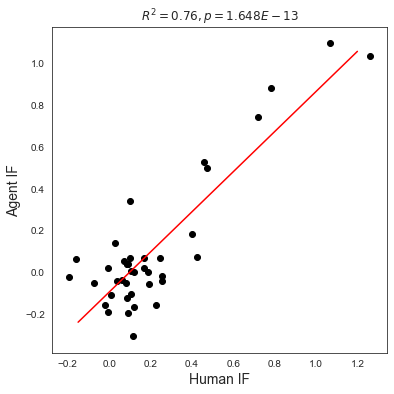

In [12]:
figure = plt.figure(figsize=(6, 6))

reg = LinearRegression().fit(np.array(flex_idcs_hums).reshape(-1, 1), np.array(flex_idcs_ag).reshape(-1,1))

x_pred = np.linspace(-0.15, 1.2, 20)
y_pred = reg.predict(x_pred.reshape(-1, 1))
r, p = scipy.stats.pearsonr(flex_idcs_hums, flex_idcs_ag)

plt.scatter(flex_idcs_hums, flex_idcs_ag, c='k')
plt.plot(x_pred, y_pred, c='r')
plt.xlabel('Human IF', fontsize=14)
plt.ylabel('Agent IF', fontsize=14)
plt.title(r'$R^{2}=%.2f, p=%.3E$'%(r**2, p));

### Save params

In [16]:
root = '/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Data/fits/'

In [17]:
e = []
for i in range(40):
    df = pd.read_csv(os.path.join(root, 'save_params_%u'%i, 'backup.txt'), header=None, sep='\t', index_col=False, skiprows=1)
    np.save(os.path.join(root, 'save_params_%u'%i, 'params.npy'), df.iloc[-1].values[:18])
    e.append(df.iloc[-1].values[18])

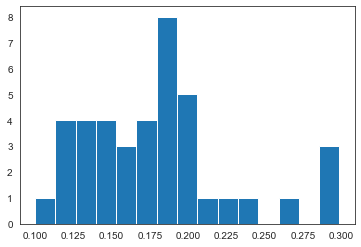

In [20]:
plt.hist(e, bins=15);
plt.savefig(os.path.join(root_folder, 'Paper/Figures_data/supp9/', 'final_errors.svg'), transparent=True)
np.save(os.path.join(root_folder, 'Paper/Figures_data/supp9/', 'fit_errs.npy'), e)

### Analyse replays of just-taken transitions

In [48]:
sub_task_folder = os.path.join(root_folder, 'Data/task/16')
opt, subopt, H_opt_single, H_subopt_single, H_opt_paired, H_subopt_paired = analyse_recent_replays(sub_task_folder)

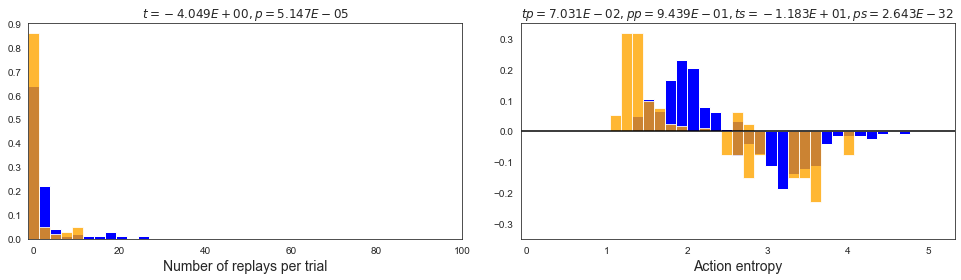

In [50]:
plt.figure(figsize=(14, 4))

# Replays
plt.subplot(1, 2, 1)
bins = np.linspace(0, 100, 40)
subopt_h, subopt_b, subopt_w = histogram(subopt, bins)
plt.bar(subopt_b, subopt_h, width=subopt_w, facecolor='b')
opt_h, opt_b, subopt_w = histogram(opt, bins)
plt.bar(opt_b, opt_h, width=subopt_w, facecolor='orange', alpha=0.8)
plt.xlabel('Number of replays per trial', fontsize=14)
plt.xlim(0-subopt_w/2, 100)
# plt.xticks(np.arange(0, 40, 5), np.arange(0, 40, 5), fontsize=10)
t, p = scipy.stats.ranksums(opt, subopt)
# t, p = permutation_test(opt, subopt, 100000)
plt.title(r'$t=%.3E, p=%.3E$'%(t, p));
plt.ylim(0, 0.9)

# Single entropy
plt.subplot(1, 2, 2)
bins=np.linspace(0, np.log2(7)+np.log2(6), 40)
H_subopt_h, H_subopt_b, H_subopt_w = histogram(H_subopt_single, bins)
plt.bar(H_subopt_b, H_subopt_h, width=H_subopt_w, facecolor='b')
H_opt_h, H_opt_b, _ = histogram(H_opt_single, bins)
plt.bar(H_opt_b, H_opt_h, width=H_subopt_w, facecolor='orange', alpha=0.8)
plt.xlim(0-H_subopt_w/2, np.log2(7)+np.log2(6)-H_subopt_w/2)

# Paired entropy
H_subopt_h, H_subopt_b, _ = histogram(H_subopt_paired, bins)
plt.bar(H_subopt_b, -H_subopt_h, width=H_subopt_w, facecolor='b')
H_opt_h, H_opt_b, _ = histogram(H_opt_paired, bins)
plt.bar(H_opt_b, -H_opt_h, width=H_subopt_w, facecolor='orange', alpha=0.8)
# plt.axvline(np.log2(7)+H_subopt_w/4)

plt.ylim(-0.35, 0.35)
plt.axhline(0, c='k')
plt.xlabel('Action entropy', fontsize=14)
ts, ps = scipy.stats.ranksums(H_opt_single, H_subopt_single)
tp, pp = scipy.stats.ranksums(H_opt_paired, H_subopt_paired)
# ts, ps = permutation_test(H_opt_single, H_subopt_single, 100000)
# tp, pp = permutation_test(H_opt_paired, H_subopt_paired, 100000)
plt.title(r'$tp=%.3E, pp=%.3E, ts=%.3E, ps=%.3E$'%(tp, pp, ts, ps));
plt.tight_layout()
# 
# plt.savefig('/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Paper/Figures_data/Figure5/recent_replays.svg', format='svg', transparent=True)

In [51]:
H_opt_paired_exp    = H_opt_paired.copy()
H_subopt_paired_exp = H_subopt_paired.copy()
H_opt_single_exp    = H_opt_single.copy()
H_subopt_single_exp = H_subopt_single.copy()

opt_all_exp    = opt.copy()
subopt_all_exp = subopt.copy()

### Analyse replays of other transitions

In [52]:
sub_task_folder = os.path.join(root_folder, 'Data/task/16')
opt, subopt, H_opt_single, H_subopt_single, H_opt_paired, H_subopt_paired = analyse_other_replays(sub_task_folder)

(0, 5.39231742277876)

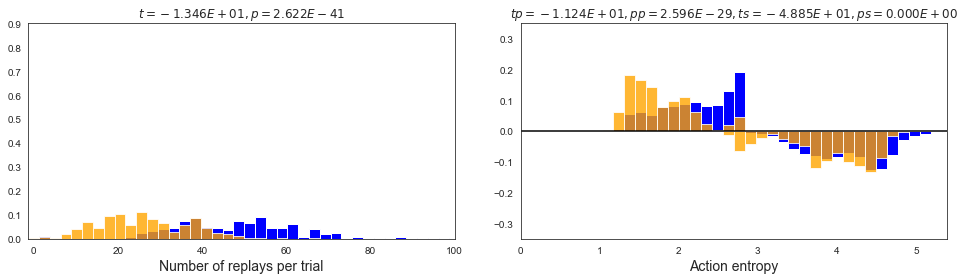

In [53]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
bins = np.linspace(0, 100, 40)
subopt_h, subopt_b, subopt_w = histogram(subopt, bins)
plt.bar(subopt_b, subopt_h, width=subopt_w, facecolor='b')
opt_h, opt_b, subopt_w = histogram(opt, bins)
plt.bar(opt_b, opt_h, width=subopt_w, facecolor='orange', alpha=0.8)
plt.xlabel('Number of replays per trial', fontsize=14)
plt.xlim(0-subopt_w/2, 100)
# plt.xticks(np.arange(0, 40, 5), np.arange(0, 40, 5), fontsize=10)
t, p = scipy.stats.ranksums(opt, subopt)
# t, p = permutation_test(opt, subopt, 100000)
plt.title(r'$t=%.3E, p=%.3E$'%(t, p));
plt.ylim(0, 0.9)

# Single entropy
plt.subplot(1, 2, 2)
bins=np.linspace(0, np.log2(7)+np.log2(6), 40)
H_subopt_h, H_subopt_b, H_subopt_w = histogram(H_subopt_single, bins)
plt.bar(H_subopt_b, H_subopt_h, width=H_subopt_w, facecolor='b')
H_opt_h, H_opt_b, _ = histogram(H_opt_single, bins)
plt.bar(H_opt_b, H_opt_h, width=H_subopt_w, facecolor='orange', alpha=0.8)
plt.xlim(0-H_subopt_w/2, np.log2(7)+np.log2(6)+H_subopt_w/2)

# Paired entropy
H_subopt_h, H_subopt_b, _ = histogram(H_subopt_paired, bins)
plt.bar(H_subopt_b, -H_subopt_h, width=H_subopt_w, facecolor='b')
H_opt_h, H_opt_b, _ = histogram(H_opt_paired, bins)
plt.bar(H_opt_b, -H_opt_h, width=H_subopt_w, facecolor='orange', alpha=0.8)

plt.ylim(-0.35, 0.35)
plt.axhline(0, c='k')
plt.xlabel('Action entropy', fontsize=14)
ts, ps = scipy.stats.ranksums(H_opt_single, H_subopt_single)
tp, pp = scipy.stats.ranksums(H_opt_paired, H_subopt_paired)
plt.title(r'$tp=%.3E, pp=%.3E, ts=%.3E, ps=%.3E$'%(tp, pp, ts, ps));
plt.tight_layout()

plt.xlim([0, np.log2(7)+np.log2(6)])

# plt.savefig('/Users/GA/Documents/Dayan_lab/Optimism_And_Pessimism_In_Optimised_Replay/Paper/Figures_data/Figure5/other_replays.svg', format='svg', transparent=True)

In [54]:
t, p_ent_opt = scipy.stats.ranksums(H_opt_paired_exp, H_opt_paired)
print('H_opt_paired_exp vs H_opt_paired:       t = %.3E, p = %.3E'%(t, p_ent_opt))
t, p_ent_opt = scipy.stats.ranksums(H_opt_single_exp, H_opt_single)
print('H_opt_single_exp vs H_opt_single:       t = %.3E, p = %.3E'%(t, p_ent_opt))
t, p_ent_subopt = scipy.stats.ranksums(H_subopt_paired_exp, H_subopt_paired)
print('H_subopt_paired_exp vs H_subopt_paired: t = %.3E, p = %.3E'%(t, p_ent_subopt))
t, p_ent_subopt = scipy.stats.ranksums(H_subopt_single_exp, H_subopt_single)
print('H_subopt_single_exp vs H_subopt_single: t = %.3E, p = %.3E'%(t, p_ent_subopt))

t, p_subopt = scipy.stats.ranksums(subopt_all_exp, subopt)
print('subopt_all_exp vs subopt_all: t = %.3E, p = %.3E'%(t, p_subopt))

t, p_opt = scipy.stats.ranksums(opt_all_exp, opt)
print('opt_all_exp vs opt_all:       t = %.3E, p = %.3E'%(t, p_opt))

H_opt_paired_exp vs H_opt_paired:       t = -4.130E+00, p = 3.633E-05
H_opt_single_exp vs H_opt_single:       t = -1.192E+01, p = 8.901E-33
H_subopt_paired_exp vs H_subopt_paired: t = -1.512E+01, p = 1.123E-51
H_subopt_single_exp vs H_subopt_single: t = -9.559E+00, p = 1.186E-21
subopt_all_exp vs subopt_all: t = -1.412E+01, p = 2.990E-45
opt_all_exp vs opt_all:       t = -1.619E+01, p = 5.827E-59


### Capture behaviour

In [71]:
sub        = 16
sub_folder = os.path.join(root_folder, 'Data/task/', str(sub))

for i in range(5):
    if i == 0:
        this_range = 6
    else:
        this_range = 7
    
    if i in [0, 1]:
        Q1_true, Q2_true = get_Q_true(world1, idcs1)
    elif i in [2, 3]:
        Q1_true, Q2_true = get_Q_true(world2, idcs1)
    else:
        Q1_true, Q2_true = get_Q_true(world2, idcs2)
                
    c = 0
    for j in range(this_range):
        # Prepare to load files
        os.chdir(os.path.join(sub_folder, str(i), str(j)))
        all_files = glob.glob('*.npz')
        # Sort files by episode number
        episodes = [int(''.join(c for c in f if c.isdigit())) for f in all_files]
        idcs     = [i[0] for i in sorted(enumerate(episodes), key=lambda x:x[1])]
        all_files_sorted = [all_files[i] for i in idcs] 

        for f in range(len(all_files_sorted)):
            
            this_file = all_files_sorted[f]
            data      = np.load(this_file, allow_pickle=True)
            move      = data['move']
            if move.shape[0] == 4:
                s = move[0]
                a = move[1]
                if s == 3 and a == 0:
#                 if a not in get_optimal_move(s, Q2_true):
                    print('Block: %u, folder: %u, trial: %u'%(i,j,f), move)
            else:
                s1 = move[0, 0]
                a1 = move[0, 1]
                
                s2 = move[1, 0]
                a2 = move[1, 1]
                
                if s2 == 3 and a2 == 0:
                    print('Block: %u, folder: %u, trial: %u'%(i,j,f), move)
            c += 1

Block: 1, folder: 0, trial: 2 [ 3  0 10  7]
Block: 2, folder: 4, trial: 0 [[2 3 9 3]
 [3 0 2 7]]
Block: 4, folder: 6, trial: 7 [[0 3 9 3]
 [3 0 0 2]]


In [66]:
# file     = 5
# data     = '/Users/GA/Documents/Dayan_lab/Data/Eran/new_task/%u/1/5/move%u.npz'%(sub, file)
# data_pre = '/Users/GA/Documents/Dayan_lab/Data/Eran/new_task/%u/1/5/move%u.npz'%(sub, file-1)
# params   = '/Users/GA/Documents/Dayan_lab/Data/Eran/new_fits/save_params_%u/params.npy'%sub

# block    = 2
# epoch    = 6
# file     = 4

# block    = 3
# epoch    = 6
# file     = 9
data     = os.path.join(root_folder, 'Data/task/%u/%u/%u/move%u.npz'%(sub, block, epoch, file))

if file == 0:
    specs = (sub, block, epoch-1, 5)
else:
    specs = (sub, block, epoch, file-1)
    
data_pre = os.path.join(root_folder, 'Data/task/%u/%u/%u/move%u.npz'%specs)
params   = os.path.join(root_folder, 'Data/fits/save_params_%u/params.npy'%sub)
p        = np.load(params)
z        = np.load(data, allow_pickle=True)

In [67]:
move = z['move']
print(move)

[[3 0 2 7]
 [7 2 8 6]]


In [68]:
replays = np.zeros(32)
replay_backups  = z['replay_backups']
for rid in range(replay_backups.shape[0]):
    this_replay = replay_backups[rid, :]
    sr = int(this_replay[0])
    ar = int(this_replay[1])
    rr = this_replay[2]
    s1r = this_replay[3]
    
    pl = int(this_replay[4])
#     pl = 1
    if sr != -200 and ar != -200 and pl == 1:
        print(rid, ':', [sr, ar, rr, s1r])
        replays[sr*4 +ar] += 1

1 : [4, 3, 8.355661791318042, 5.0]
2 : [6, 2, 8.286730215472549, 5.0]
4 : [1, 1, 7.756907801731156, 5.0]
5 : [2, 3, 7.736702142652376, 3.0]
7 : [6, 2, 8.286730215472549, 5.0]
8 : [4, 3, 8.355661791318042, 5.0]
13 : [2, 3, 7.736702142652376, 3.0]
14 : [3, 1, 3.0638362410793984, 7.0]
15 : [3, 2, 1.7952887470029215, 2.0]
16 : [1, 1, 7.756907801731156, 5.0]
17 : [0, 2, 7.293203322492918, 3.0]
19 : [5, 0, 2.7504940674908744, 1.0]
22 : [6, 2, 8.286730215472549, 5.0]
23 : [2, 3, 7.736702142652376, 3.0]
24 : [0, 2, 7.293203322492918, 3.0]
25 : [4, 3, 8.355661791318042, 5.0]
27 : [1, 1, 7.756907801731156, 5.0]
29 : [5, 1, 3.7169704524390714, 1.0]
34 : [0, 2, 7.293203322492918, 3.0]
37 : [2, 3, 7.736702142652376, 3.0]
38 : [3, 1, 3.0638362410793984, 7.0]
39 : [1, 1, 7.756907801731156, 5.0]
41 : [5, 2, 4.619205748418332, 4.0]
42 : [6, 2, 8.286730215472549, 5.0]
45 : [4, 3, 8.355661791318042, 5.0]
46 : [0, 2, 7.293203322492918, 3.0]
48 : [2, 3, 7.736702142652376, 3.0]
50 : [1, 1, 7.756907801731156

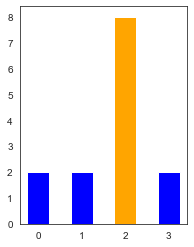

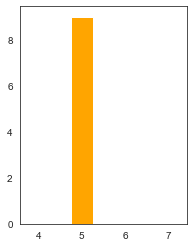

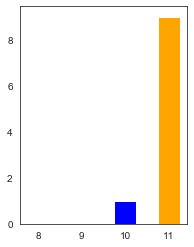

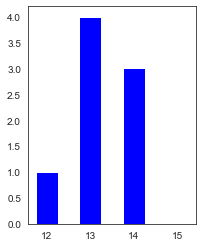

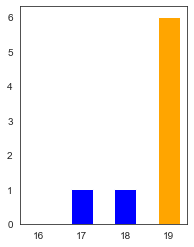

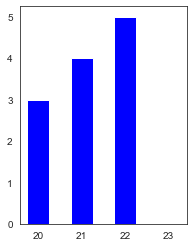

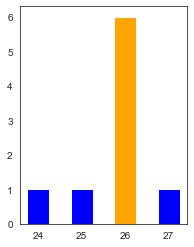

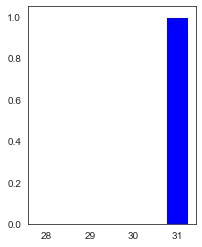

In [69]:
_, Q2_true = get_Q_true(world2, idcs1)
for s in range(8):
    fig = plt.figure(figsize=(3, 4))
    for a in range(4):
        if a in get_optimal_move(s, Q2_true):
            plt.bar(s*4+a, replays[s*4+a], facecolor='orange', align='center', width=0.5)
        else:
            plt.bar(s*4+a, replays[s*4+a], facecolor='b', align='center', width=0.5)
#     plt.ylim(0, 3)
#     plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure5/Replays/capture_%u_%u.svg'%(sub, s), transparent=True, format='svg')
# plt.xticks(range(32), range(32));
# plt.title('Replays after move s=%u, a=%u'%(z['move'][1][0], z['move'][1][1]), fontsize=14);


In [ ]:
Q = z['Q2_history']
# Q = z['Q_history']
Q_before = Q[0].reshape(8, -1)
Q_after  = Q[-1].reshape(8, -1)

_, Q2_true = get_Q_true(world2, idcs1)

beta = p[0]
a    = p[10]
b    = p[11]
d    = -(a+b)
biases = np.array([a, b, 0, d])

fig = plt.figure(figsize=(14, 3))
for s in range(8):
    opt = policy_improve(Q_before[s, :], Q_after[s, :], Q2_true, s, beta, biases, world2, idcs1, mode='value')
    print('State %u, opt: %.5f'%(s, opt))
    plt.bar(s, opt, facecolor='orange', width = 0.4)
#     plt.axhline(0, c='k')
plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure5/capture_%u_policy.svg'%sub, transparent=True, format='svg')


In [ ]:
fig = plt.figure(figsize=(16, 4))
max_ent = np.log2(7)

T = z['T']
for s in range(8):
    for a in range(4):
        ent = get_entropy(T, s, a)
        alp = 1-(ent/max_ent)
        if alp < 0:
            alp = 0
        plt.bar(s*4+a, ent, facecolor='k', width=0.5, alpha = alp)
        print(s, a, 'alpha:', np.round(alp*100))
plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure5/capture_%u_entropy.svg'%sub, transparent=True, format='svg')
plt.xticks(range(32), range(32));

In [ ]:
_, Q2_true = get_Q_true(world2, idcs1)

Q     = z['Q2_history'][0].reshape(8, 4)

alpha = p[3]
T     = z['T']
tau   = p[8]

rew_hist = z['rew_history'][1]
av_rew   = np.mean(rew_hist)

Q_pre    = (Q  - av_rew*(tau-1))/tau

Q_before = Q_pre.copy()
Q_before[int(move[1][0]), int(move[1][1])] = (Q_pre[int(move[1][0]), int(move[1][1])] - alpha*move[1][2])/(1-alpha)

# r = 2
# Q_pre    = (Q_before - alpha*r)/(1-alpha)

In [ ]:
for s in range(8):
    fig = plt.figure(figsize=(3, 4))
    a_opt = get_optimal_move(s, Q2_true)
    for a in range(4):
        this_action_probas = T[s, a, :]
        r = np.sum(world2.ravel()*this_action_probas)
        if a in a_opt:
            plt.bar(s*4+a, Q_pre[s, a], facecolor='orange', edgecolor='orange', align='center',width=0.3)
            plt.bar(s*4+a+0.35, r, facecolor='pink', width=0.3)
        else:
            if s == int(move[1][0]) and a == int(move[1][1]):
#             if s == int(move[0]) and a == int(move[1]):
                plt.bar(s*4+a, Q_before[s, a], facecolor='green', edgecolor='green', align='center',width=0.3)
                print(Q_pre[s, a], Q_before[s, a], r)
            plt.bar(s*4+a, Q_pre[s, a], facecolor='b', edgecolor='b', align='center',width=0.3)
            plt.bar(s*4+a+0.35, r, facecolor='pink', width=0.3)
        plt.hlines(Q2_true[s, a], s*4+a-0.13, s*4+a+0.5)
    plt.ylim(0, 11)
    plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure5/Q/Q_before_%u.svg'%s, transparent=True, format='svg')

# fig = plt.figure(figsize=(16, 4))
# Q_after = Q[-1, :].reshape(8, 4)
# for s in range(8):
#     a_opt = get_optimal_move(s, Q2_true)
#     for a in range(4):
#         if a in a_opt:
#             plt.bar(s*4+a, Q_before[s, a], facecolor='orange', width=0.5)
#         else:
#             plt.bar(s*4+a, Q_before[s, a], facecolor='b', width=0.5)
#     plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures/Q_after.svg', transparent=True, format='svg')

### Policy improvements

In [ ]:
root_folder   = '/Users/GA/Documents/Dayan_lab/Data/Eran/task/'

opt_all = []

for sub in [19]:
    
    opt_sub = []
    
    params = '/Users/GA/Documents/Dayan_lab/Data/Eran/fits/save_params_%u/params.npy'%sub
    
    p     = np.load(params)
    beta  = p[0]
    beta2 = p[1]
    beta1 = p[2]
    a     = p[10]
    b     = p[11]
    d     = -(a+b)
    biases = np.array([a, b, 0, d])

    for i in range(1, 5):
        if i == 0:
            this_range = 6
        else:
            this_range = 7
        
        if i in [0, 1]:
            world = world1
            idcs  = idcs1
            Q1_true, Q2_true = get_Q_true(world, idcs)
        elif i in [2, 3]:
            world = world2
            idcs  = idcs1
            Q1_true, Q2_true = get_Q_true(world, idcs)
        else:
            world = world2
            idcs  = idcs2
            Q1_true, Q2_true = get_Q_true(world, idcs)
        
        for j in range(this_range):
            if i > 0 and j < 2:
                pass
            else:
                # Prepare to load files
                os.chdir(os.path.join(root_folder, str(sub), str(i), str(j)))
                all_files = glob.glob('*.npz')
                # Sort files by episode number
                episodes = [int(''.join(c for c in f if c.isdigit())) for f in all_files]
                idcs_ep  = [i[0] for i in sorted(enumerate(episodes), key=lambda x:x[1])]
                all_files_sorted = [all_files[i] for i in idcs_ep] 

                for f in range(len(all_files_sorted)):

                    tmp_opt = []

                    this_file = all_files_sorted[f]
                    data      = np.load(this_file, allow_pickle=True)
                    move      = data['move']

                    if len(move) == 2:
    #                     pass
                        replay_backups = np.atleast_2d(data['replay_backups'])
                        if replay_backups.shape[0] > 1:

                            Q1 = data['Q1_history']
                            Q2 = data['Q2_history']

                            Q1_before = Q1[0, :].reshape(8, -1)
                            Q1_after  = Q1[-1, :].reshape(8, -1)

                            Q2_before = Q2[0, :].reshape(8, -1)
                            Q2_after  = Q2[-1, :].reshape(8, -1)

                            states = np.unique(replay_backups[1:, 0])
                            states = [int(i) for i in states]

                            for s in states:
                                opt = policy_improve_2moves(Q1_before[s, :], Q1_after[s, :], Q2_before[s, :], Q2_after[s, :], Q1_true, s, beta1, beta2, biases, world, idcs, mode='value')
                                tmp_opt    += [float(opt)]
                            
                            opt_sub    += [np.mean(tmp_opt)]

                    else:
                        replay_backups = np.atleast_2d(data['replay_backups'])
                        if replay_backups.shape[0] > 1:

                            Q = data['Q_history']

                            Q_before = Q[0, :].reshape(8, -1)
                            Q_after  = Q[-1, :].reshape(8, -1)

                            states = np.unique(replay_backups[1:, 0])
                            states = [int(i) for i in states]

                            for s in states:
                                opt = policy_improve(Q_before[s, :], Q_after[s, :], Q2_true, s, beta, biases, world, idcs, mode='value')
                                tmp_opt    += [float(opt)]
                                    
                            opt_sub += [np.mean(tmp_opt)]
    
    opt_all.append(np.mean(opt_sub))

In [ ]:
opt_all = opt_sub

In [ ]:
fig = plt.figure(figsize=(2, 5))

plt.bar(1, np.nanmean(opt_all), facecolor='#22CF00', alpha=0.4, width=0.1)
plt.scatter([1]*len(opt_all), opt_all, c='#22CF00', alpha=1)
plt.axhline(0, c='k')
plt.xticks([1], ['Optimal'],fontsize=14)
plt.ylabel(r'$Average \; \; \Delta \pi(a \mid s) \; \; over \; \; states$', fontsize=14)
# plt.ylim(-4, 4)
# plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/Figure5/policy_improve_prob.svg', format='svg', transparent=True)

In [ ]:
print('Opt policy change:    test statistic: %.3f,  p-value: %.3E' % scipy.stats.ttest_1samp(opt_all, 0))

In [ ]:
print('Policy change opt   :', np.nanmean(opt_all))

### Re-arranged Model Entropy 

In [ ]:
task_folder   = '/Users/GA/Documents/Dayan_lab/Data/Eran/task/'
params_folder = '/Users/GA/Documents/Dayan_lab/Data/Eran/fits/'

subs_who_replay = np.load(os.path.join(task_folder, 'Analysis', 'subs_who_replay.npy'))

before = []
after  = []
ents   = []

_, Q2_true = get_Q_true(world2, idcs2)

for sub in subs_who_replay:
    
    sub_task_folder = os.path.join(task_folder, str(sub))
    
    rho = np.load(os.path.join(params_folder, 'save_params_%u'%sub, 'params.npy'))[12]
    
    # Model entropy before re-arrangement
    file = os.path.join(sub_task_folder, '3', '6', 'move11.npz')
    data = np.load(file, allow_pickle=True)
    T    = data['T']
    T    = rho*T + (1-rho)*(1./7)
    
    for i in range(T.shape[0]):
        for j in range(T.shape[1]):
            T[i, j, i]  = 0

            row = T[i, j, :]
            tmp = np.sum(row)
            if tmp > 0:
                T[i, j, :] = row / tmp
    
    # optimal action entropy without rearrangement
    tmp = 0
    for s in range(8):
        for a in range(4):
            tmp += np.power(Q2_true[s, a]-np.sum(T[s, a, :]*world2.ravel()), 2)
    before.append(tmp/32)
    
    root_folder = '/Users/GA/Documents/Dayan_lab/Data/Eran/task/'

    tmp = []
    for s in range(8):
        a_opt = get_optimal_move(s, Q2_true)
        this_ent = get_entropy(T, s, a_opt)
        if len(this_ent) > 1:
            this_ent = np.mean(this_ent)
        else:
            this_ent = this_ent[0]
        tmp.append(this_ent)
    ents.append(np.mean(tmp))
    
    file = os.path.join(sub_task_folder, '3', 'offline.npz')
    data = np.load(file, allow_pickle=True)
    T    = data['T']
    
    # optimal action entropy with rearrangement
    tmp = 0
    for s in range(8):
        for a in range(4):
            tmp += np.power(Q2_true[s, a]-np.sum(T[s, a, :]*world2.ravel()), 2)
    after.append(tmp/32)

In [ ]:
x = flex_subs
y = before

model = LinearRegression()
model.fit(x.reshape(-1, 1), y.reshape(-1, 1))

r, p   = pearsonr(x, y)

x_pred = np.linspace(-0.2, 1).reshape(-1, 1)
y_pred = model.predict(x_pred)

plt.scatter(x, y)
plt.plot(x_pred, y_pred)

In [ ]:
plt.figure(figsize=(4, 5))

plt.bar(1, np.mean(after), facecolor='orange', alpha=0.6, align='center')
plt.scatter([1]*len(after), after, c='orange')
plt.bar(2, np.mean(before), facecolor='b', alpha=0.6, align='center')
plt.scatter([2]*len(before), before, c='b')
plt.axhline(0, c='k')
for i in range(len(after)):
    plt.plot([1, 2], [after[i], before[i]], c='k')


t, p = scipy.stats.ttest_ind(after, before)
print('opt vs subopt: t=%.3E, p=%.3E'%(t, p))
plt.title('W = %.3E, p = %.3E'%(t, p))

plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp3/rmsd_rearrangement.svg', transparent=True)

In [ ]:
permutation_test(r_after, r_before, 10000, rep=True)

In [ ]:
len(subs_who_replay)

In [ ]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

In [ ]:
plt.figure(figsize=(8, 5))

diff = np.array(before) - np.array(after)

x = np.array(ents).reshape(-1, 1)
y = np.array(diff).reshape(-1, 1)

reg    = LinearRegression().fit(x, y)
r, p   = pearsonr(ents, diff)

x_pred = np.linspace(np.min(ents), np.max(ents), 50).reshape(-1, 1)
y_pred = reg.predict(x_pred)
plt.scatter(ents, diff, c='r')
plt.plot(x_pred, y_pred, c='k')

plt.title('R^2 = %.3E, p = %.3E'%(r**2, p))

plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp3/rmsd_corr.svg', transparent=True)

In [ ]:
plt.figure(figsize=(8, 5))

reg    = LinearRegression().fit(np.array(ents).reshape(-1, 1), np.array(flex_subs))
r, p   = pearsonr(ents, flex_subs)
plt.scatter(ents, flex_subs, c='r')

# x_pred = np.linspace(np.min(diff), np.max(diff), 50).reshape(-1, 1)
# y_pred = reg.predict(x_pred)
# plt.plot(x_pred, y_pred, c='k')

# plt.title('R^2 = %.3E, p = %.3E'%(r**2, p))

# plt.savefig('/Users/GA/Documents/Dayan_lab/Paper/Figures_data/supp3/rmsd_corr_if.svg', transparent=True)

In [ ]:
r_after

In [ ]:
p

In [ ]:
p

In [ ]:
r**2

### MB/MF human subjects

## Flexibility

In [ ]:
path = '/Users/GA/Documents/Dayan_lab/Data/Eran/TTASKK'

for sub in range(40):
    this_sub = os.path.join(path, str(sub))
    for i in range(10):
        r = []
        this_inst = os.path.join(this_sub, str(i))
        for j in range(5):
            tmp = []
            os.chdir(os.path.join(this_inst, str(j)))
            all_files = glob.glob('*.npy')
            episodes = [int(''.join(c for c in f if c.isdigit())) for f in all_files]
            idcs_ep  = [i[0] for i in sorted(enumerate(episodes), key=lambda x:x[1])]
            all_files_sorted = [all_files[i] for i in idcs_ep] 
            for f in all_files_sorted:
                data = np.load(f)
                for m in range(len(data)):
                    if len(data[m]) == 4:
                        tmp += [data[m][2]]
                    else:
                        tmp += [data[m][0][2] + data[m][1][2]]
            r += [tmp]
        np.save(os.path.join(this_inst, 'blocks_obt_rwd.npy'), r)

In [ ]:
x = np.array([-0.1, -0.05, 0, 0.1, 0.2, 0.2])

In [ ]:
np.argwhere(x > 0).flatten()